In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-scatter 2.1.0+pt113cu116
Uninstalling torch-scatter-2.1.0+pt113cu116:
  Successfully uninstalled torch-scatter-2.1.0+pt113cu116
Found existing installation: torch-sparse 0.6.15+pt113cu116
Uninstalling torch-sparse-0.6.15+pt113cu116:
  Successfully uninstalled torch-sparse-0.6.15+pt113cu116
Found existing installation: torch-geometric 2.2.0
Uninstalling torch-geometric-2.2.0:
  Successfully uninstalled torch-geometric-2.2.0
Found existing installation: torch-cluster 1.6.0+pt113cu116
Uninstalling torch-cluster-1.6.0+pt113cu116:
  Successfully uninstalled torch-cluster-1.6.0+pt113cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_scatter-2.1.0%2Bpt113cu116-cp38-cp38-linux_x86_64.whl (9.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [3]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data, Dataset
from itertools import product
class EEGGraphDataset(Dataset):
	def __init__(self, X, y, indices, loader_type, sfreq, transform=None):

		self.epochs = X
		self.labels = y
		self.indices = indices
		self.sfreq = sfreq
		self.loader_type = loader_type
		self.transform = transform

		self.ch_names = ['EEG FP1','EEG FP2','EEG F3','EEG F4','EEG C3','EEG C4','EEG P3','EEG P4','EEG O1','EEG O2','EEG F7','EEG F8','EEG T3','EEG T4','EEG T5','EEG T6','EEG FZ','EEG CZ','EEG PZ']
		self.ref_names = ['EEG FP1','EEG FP2','EEG F3','EEG F4','EEG C3','EEG C4','EEG P3','EEG P4','EEG O1','EEG O2','EEG F7','EEG F8','EEG T3','EEG T4','EEG T5','EEG T6','EEG FZ','EEG CZ','EEG PZ']

		self.node_ids = range(len(self.ch_names))
		self.edge_index = torch.tensor([[a,b] for a, b in product(self.node_ids, self.node_ids)], dtype=torch.long).t().contiguous()
		self.distances = self.get_sensor_distances()
		a = np.array(self.distances)
		self.distances = (a - np.min(a))/(np.max(a) - np.min(a))

	def get_sensor_distances(self):
		num_edges = self.edge_index.shape[1]
		distances = [ ]
		for edge_idx in range(num_edges): 
			sensor1_idx = self.edge_index[0, edge_idx]
			sensor2_idx = self.edge_index[1, edge_idx]
			dist = self.get_geodesic_distance(sensor1_idx, sensor2_idx)
			distances.append(dist)
		assert len(distances) == num_edges
		return distances

	def get_geodesic_distance(self, montage_sensor1_idx, montage_sensor2_idx):
		
		ref_sensor1 = self.ref_names[montage_sensor1_idx]
		ref_sensor2 = self.ref_names[montage_sensor2_idx]
		distances = pd.read_csv('./drive/MyDrive/ML_Project/distances_3d.csv')
		for row in range(int(distances.shape[0])):
			if(distances.iloc[row][0]==ref_sensor1 and distances.iloc[row][1]==ref_sensor2):
				return distances.iloc[row][2]
			if(distances.iloc[row][1]==ref_sensor1 and distances.iloc[row][0]==ref_sensor2):
				return distances.iloc[row][2]
		return 0

	def __len__(self):
		return len(self.indices)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()
		idx = self.indices[idx]
		node_features = self.epochs[idx]
		node_features = torch.from_numpy(node_features.reshape(19, 6))
		
		edge_weights = self.distances
		edge_weights = torch.tensor(edge_weights)
		data = Data(x=node_features, edge_index=self.edge_index, edge_attr=edge_weights,dataset_idx=idx, y=self.labels[idx])
		return data


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm, global_add_pool


class EEGGraphConvNet(nn.Module):
    def __init__(self, reduced_sensors=None, sfreq=None):
        super(EEGGraphConvNet, self).__init__()
		
        self.sfreq = sfreq
        self.input_size = 19
        self.conv1 = GCNConv(6, 36, improved=True, cached=True, normalize=False)
        self.conv2 = GCNConv(36, 216, improved=True, cached=True, normalize=False)
        self.conv3_bn = BatchNorm(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.fc_block1 = nn.Linear(216, 150)
        self.fc_block2 = nn.Linear(150, 50)
        self.fc_block3 = nn.Linear(50, 9)

    def forward(self, x, edge_index, edge_weight, batch, return_graph_embedding=False):
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3_bn(self.conv2(x, edge_index, edge_weight)))
        out = global_add_pool(x, batch=batch)
        if return_graph_embedding:
            return out
        out = F.leaky_relu(self.fc_block1(out), negative_slope=0.01)
        out = F.dropout(out, p = 0.2, training=self.training)
        out = F.leaky_relu(self.fc_block2(out), negative_slope=0.01)
        out = self.fc_block3(out)
        return out

In [5]:
from sklearn.model_selection import train_test_split

from joblib import load
import statistics as stats
from sklearn import preprocessing

import torch.backends.cudnn as cudnn
cudnn.enabled = True
cudnn.benchmark = False
cudnn.deterministic = True

from torch_geometric.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torchvision.transforms import Compose, ToTensor
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
from sklearn.utils import class_weight


def get_patient_prediction(df, fold_idx):
	unique_patients = list(df["patient_ID"].unique())
	grouped_df = df.groupby("patient_ID")
	rows = [ ]
	for patient in unique_patients:
		patient_df = grouped_df.get_group(patient)
		temp = { }
		temp["patient_ID"] = patient
		temp["y_true"] = list(patient_df["y_true"].unique())[0]
		temp["y_pred"] = patient_df["y_pred"].mode()[0]
		temp["y_probs"] = patient_df["y_probs"].mean()
		rows.append(temp)
	return_df = pd.DataFrame(rows)

	return np.array(list(return_df["y_probs"])), list(return_df["y_true"]), list(return_df["y_pred"])


if __name__ == "__main__":

	GPU_IDX = 0
	EXPERIMENT_NAME = "eeg_gnn"
	BATCH_SIZE = 32
	SFREQ = 250.0
	NUM_EPOCHS = 150
	WORKERS = 2

	MASTER_DATASET_INDEX = 7200
	train_indices = []
	test_subjects = []
	val_indices = []
	rem_subjects = []

	DEVICE = torch.device('cuda:{}'.format(GPU_IDX) if torch.cuda.is_available() else 'cpu')
	
	X = np.load("./drive/MyDrive/ML_Project/X_psd_epilepsy_corpus.npy", allow_pickle=True)
	y = np.load("./drive/MyDrive/ML_Project/y_epilepsy_corpus.npy", allow_pickle=True)
  
	pinf = float('+inf')
	ninf = float('-inf')
	fnan = float('nan')
	for i in range(len(X)):
		for j in range(len(X[i])):
			if X[i][j]==pinf:  
				X[i][j]=1
			elif X[i][j]==ninf:  
				X[i][j]=-1
			elif X[i][j]==fnan:  
				X[i][j]=0
	
	indices = []
	for i in range(len(y)):
		indices.append(i)
	train_indices, test_subjects = train_test_split(indices, test_size=0.2)
	train_indices, val_indices = train_test_split(train_indices, test_size=0.2)
	X_train, X_test, X_val = [], [], []
	y_train, y_test, y_val = [], [], []
	for i in train_indices:
		X_train.append(X[i])
		y_train.append(y[i])
	for i in test_subjects:
		X_test.append(X[i])
		y_test.append(y[i])
	for i in val_indices:
		X_val.append(X[i])
		y_val.append(y[i])

	X_train, y_train = np.array(X_train), np.array(y_train)
	X_test, y_test = np.array(X_test), np.array(y_test)
	X_val, y_val = np.array(X_val), np.array(y_val)
  
	class_weights = class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(y_train),y= y_train)
	class_weights=torch.tensor(class_weights,dtype=torch.float)
	print(class_weights)
 
	normd_x = []
	for i in range(len(y)):
		arr = X[i, :]
		arr = arr.reshape(1, -1)
		arr2 = preprocessing.normalize(arr)
		arr2 = arr2.reshape(19*6)
		normd_x.append(arr2)
	
	norm = np.array(normd_x)
	X = norm.reshape(len(y), 19*6)

	label_mapping, y_train = np.unique(y_train, return_inverse = True)
	label_mapping_test, y_test = np.unique(y_test, return_inverse = True)
	label_mapping_val, y_val = np.unique(y_val, return_inverse = True)
	print("Unique labels to 0-8 mapping:", label_mapping)

	model = EEGGraphConvNet(reduced_sensors=False)
	model = model.to(DEVICE).double()

	labels_unique, counts = np.unique(y, return_counts=True)

	train_dataset = EEGGraphDataset(X=X_train, y=y_train, indices=[i for i in range(len(X_train))], loader_type="train", sfreq=SFREQ, transform=Compose([ToTensor()]))
	train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = WORKERS)
	
	val_dataset = EEGGraphDataset(X=X_val, y=y_val, indices=[i for i in range(len(X_val))], loader_type="validation", sfreq=SFREQ, transform=Compose([ToTensor()]))
	val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = WORKERS)

	loss_function = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
	scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i*10 for i in range(1, 26)], gamma=0.1)

	accuracy_pts = []
	validation_accuracy_pts = []
	loss_pts = []
	x_params = []

	for epoch in range(NUM_EPOCHS):

		model.train()
		train_loss = []
		val_loss = []

		y_probs_train = torch.empty(0, 9).to(DEVICE)

		y_true_train = [ ]
		y_pred_train = [ ]
		window_indices_train = [ ]
		losses = 0.0
		loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')

		for batch_idx, batch in enumerate(train_loader):

			X_batch = batch.to(device=DEVICE, non_blocking=True)
			y_batch = torch.tensor(batch.y)
			y_batch = y_batch.to(device=DEVICE, non_blocking=True)
			window_indices_train += X_batch.dataset_idx.cpu().numpy().tolist()
			optimizer.zero_grad()

			outputs = model(X_batch.x, X_batch.edge_index, X_batch.edge_attr, X_batch.batch).float()

			loss_ob = loss(outputs, y_batch)
			losses += loss_ob.item()
			train_loss.append(loss_ob.item())
			loss_ob.backward()

			_, predicted = torch.max(outputs.data, 1)
			y_pred_train += predicted.cpu().numpy().tolist()

			y_probs_train = torch.cat((y_probs_train, outputs.data), 0)
			y_true_train += y_batch.cpu().numpy().tolist()

			optimizer.step()
		scheduler.step()
		epoch_loss = losses / len(train_loader)
		loss_pts.append(epoch_loss)
		y_probs_train = torch.nn.functional.softmax(y_probs_train, dim=1).cpu().numpy()
		y_true_train = np.array(y_true_train)

		model.eval()
		with torch.no_grad():
			y_probs_val = torch.empty(0, 9).to(DEVICE)

			y_true_val = [ ]
			y_pred_val = [ ]
			window_indices_val = [ ]

			for i, batch in enumerate(val_loader):
				X_batch = batch.to(device=DEVICE, non_blocking=True)
				y_batch = torch.tensor(batch.y)
				y_batch = y_batch.to(device=DEVICE, non_blocking=True)
				window_indices_val += X_batch.dataset_idx.cpu().numpy().tolist()
				outputs = model(X_batch.x, X_batch.edge_index, X_batch.edge_attr, X_batch.batch).float()

				loss = loss_function(outputs, y_batch)
				val_loss.append(loss.item())

				_, predicted = torch.max(outputs.data, 1)
				y_pred_val += predicted.cpu().numpy().tolist()

				y_probs_val = torch.cat((y_probs_val, outputs.data), 0)
				y_true_val += y_batch.cpu().numpy().tolist()

		y_probs_val = torch.nn.functional.softmax(y_probs_val, dim=1).cpu().numpy()
		y_true_val = np.array(y_true_val)

		print(f'Epoch: {epoch}---', end=" | ")
		print(f"Accuracy : {sklearn.metrics.accuracy_score(y_true_train, y_pred_train):.3f}, Loss: {loss_pts[-1]:.3f}", end=" | ")
		print(f"Validation Accuracy : {sklearn.metrics.accuracy_score(y_true_val, y_pred_val):.3f}")
		accuracy_pts.append(sklearn.metrics.accuracy_score(y_true_train, y_pred_train))
		validation_accuracy_pts.append(sklearn.metrics.accuracy_score(y_true_val, y_pred_val))
		x_params.append(epoch+1)
	


tensor([2.5937e+01, 1.1763e-01, 1.2968e+01, 4.0116e+00, 8.9544e+00, 5.0144e+02,
        2.5072e+02, 8.8490e+01, 2.1490e+02])
Unique labels to 0-8 mapping: ['ABSZ' 'BCKG' 'CPSZ' 'FNSZ' 'GNSZ' 'MYSZ' 'SPSZ' 'TCSZ' 'TNSZ']


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 0--- | Accuracy : 0.619, Loss: 1.753 | Validation Accuracy : 0.402


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 1--- | Accuracy : 0.671, Loss: 1.593 | Validation Accuracy : 0.827


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 2--- | Accuracy : 0.687, Loss: 1.554 | Validation Accuracy : 0.822


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 3--- | Accuracy : 0.683, Loss: 1.513 | Validation Accuracy : 0.851


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 4--- | Accuracy : 0.683, Loss: 1.518 | Validation Accuracy : 0.864


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 5--- | Accuracy : 0.687, Loss: 1.481 | Validation Accuracy : 0.837


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 6--- | Accuracy : 0.703, Loss: 1.466 | Validation Accuracy : 0.858


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 7--- | Accuracy : 0.682, Loss: 1.456 | Validation Accuracy : 0.905


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 8--- | Accuracy : 0.700, Loss: 1.427 | Validation Accuracy : 0.857


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 9--- | Accuracy : 0.694, Loss: 1.415 | Validation Accuracy : 0.799


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 10--- | Accuracy : 0.753, Loss: 1.382 | Validation Accuracy : 0.746


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 11--- | Accuracy : 0.739, Loss: 1.362 | Validation Accuracy : 0.765


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 12--- | Accuracy : 0.733, Loss: 1.360 | Validation Accuracy : 0.746


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 13--- | Accuracy : 0.728, Loss: 1.348 | Validation Accuracy : 0.759


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 14--- | Accuracy : 0.730, Loss: 1.344 | Validation Accuracy : 0.761


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 15--- | Accuracy : 0.726, Loss: 1.335 | Validation Accuracy : 0.754


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 16--- | Accuracy : 0.724, Loss: 1.315 | Validation Accuracy : 0.749


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 17--- | Accuracy : 0.732, Loss: 1.324 | Validation Accuracy : 0.757


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 18--- | Accuracy : 0.735, Loss: 1.321 | Validation Accuracy : 0.773


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 19--- | Accuracy : 0.728, Loss: 1.320 | Validation Accuracy : 0.758


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 20--- | Accuracy : 0.718, Loss: 1.315 | Validation Accuracy : 0.754


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 21--- | Accuracy : 0.722, Loss: 1.313 | Validation Accuracy : 0.758


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 22--- | Accuracy : 0.722, Loss: 1.316 | Validation Accuracy : 0.760


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 23--- | Accuracy : 0.725, Loss: 1.311 | Validation Accuracy : 0.759


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 24--- | Accuracy : 0.721, Loss: 1.314 | Validation Accuracy : 0.760


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 25--- | Accuracy : 0.727, Loss: 1.315 | Validation Accuracy : 0.761


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 26--- | Accuracy : 0.725, Loss: 1.303 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 27--- | Accuracy : 0.728, Loss: 1.311 | Validation Accuracy : 0.761


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 28--- | Accuracy : 0.730, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 29--- | Accuracy : 0.727, Loss: 1.303 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 30--- | Accuracy : 0.723, Loss: 1.319 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 31--- | Accuracy : 0.729, Loss: 1.303 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 32--- | Accuracy : 0.725, Loss: 1.313 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 33--- | Accuracy : 0.730, Loss: 1.300 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 34--- | Accuracy : 0.726, Loss: 1.318 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 35--- | Accuracy : 0.730, Loss: 1.316 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 36--- | Accuracy : 0.729, Loss: 1.299 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 37--- | Accuracy : 0.728, Loss: 1.314 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 38--- | Accuracy : 0.729, Loss: 1.307 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 39--- | Accuracy : 0.729, Loss: 1.312 | Validation Accuracy : 0.762


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 40--- | Accuracy : 0.730, Loss: 1.295 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 41--- | Accuracy : 0.727, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 42--- | Accuracy : 0.726, Loss: 1.298 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 43--- | Accuracy : 0.729, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 44--- | Accuracy : 0.731, Loss: 1.290 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 45--- | Accuracy : 0.726, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 46--- | Accuracy : 0.730, Loss: 1.299 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 47--- | Accuracy : 0.728, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 48--- | Accuracy : 0.731, Loss: 1.285 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 49--- | Accuracy : 0.732, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 50--- | Accuracy : 0.730, Loss: 1.300 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 51--- | Accuracy : 0.732, Loss: 1.304 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 52--- | Accuracy : 0.726, Loss: 1.315 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 53--- | Accuracy : 0.729, Loss: 1.319 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 54--- | Accuracy : 0.725, Loss: 1.310 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 55--- | Accuracy : 0.730, Loss: 1.323 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 56--- | Accuracy : 0.728, Loss: 1.309 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 57--- | Accuracy : 0.728, Loss: 1.297 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 58--- | Accuracy : 0.729, Loss: 1.313 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 59--- | Accuracy : 0.731, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 60--- | Accuracy : 0.728, Loss: 1.293 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 61--- | Accuracy : 0.726, Loss: 1.308 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 62--- | Accuracy : 0.730, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 63--- | Accuracy : 0.724, Loss: 1.309 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 64--- | Accuracy : 0.731, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 65--- | Accuracy : 0.727, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 66--- | Accuracy : 0.728, Loss: 1.293 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 67--- | Accuracy : 0.729, Loss: 1.303 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 68--- | Accuracy : 0.728, Loss: 1.304 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 69--- | Accuracy : 0.724, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 70--- | Accuracy : 0.728, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 71--- | Accuracy : 0.726, Loss: 1.313 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 72--- | Accuracy : 0.723, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 73--- | Accuracy : 0.724, Loss: 1.293 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 74--- | Accuracy : 0.730, Loss: 1.315 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 75--- | Accuracy : 0.727, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 76--- | Accuracy : 0.733, Loss: 1.302 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 77--- | Accuracy : 0.724, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 78--- | Accuracy : 0.728, Loss: 1.297 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 79--- | Accuracy : 0.729, Loss: 1.303 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 80--- | Accuracy : 0.729, Loss: 1.304 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 81--- | Accuracy : 0.727, Loss: 1.298 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 82--- | Accuracy : 0.730, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 83--- | Accuracy : 0.727, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 84--- | Accuracy : 0.733, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 85--- | Accuracy : 0.728, Loss: 1.302 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 86--- | Accuracy : 0.724, Loss: 1.304 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 87--- | Accuracy : 0.728, Loss: 1.280 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 88--- | Accuracy : 0.724, Loss: 1.303 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 89--- | Accuracy : 0.730, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 90--- | Accuracy : 0.727, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 91--- | Accuracy : 0.730, Loss: 1.296 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 92--- | Accuracy : 0.726, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 93--- | Accuracy : 0.729, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 94--- | Accuracy : 0.727, Loss: 1.303 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 95--- | Accuracy : 0.728, Loss: 1.298 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 96--- | Accuracy : 0.731, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 97--- | Accuracy : 0.727, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 98--- | Accuracy : 0.730, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 99--- | Accuracy : 0.733, Loss: 1.296 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 100--- | Accuracy : 0.727, Loss: 1.320 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 101--- | Accuracy : 0.731, Loss: 1.299 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 102--- | Accuracy : 0.729, Loss: 1.294 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 103--- | Accuracy : 0.727, Loss: 1.315 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 104--- | Accuracy : 0.730, Loss: 1.300 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 105--- | Accuracy : 0.728, Loss: 1.295 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 106--- | Accuracy : 0.730, Loss: 1.294 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 107--- | Accuracy : 0.728, Loss: 1.313 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 108--- | Accuracy : 0.730, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 109--- | Accuracy : 0.730, Loss: 1.299 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 110--- | Accuracy : 0.726, Loss: 1.296 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 111--- | Accuracy : 0.728, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 112--- | Accuracy : 0.727, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 113--- | Accuracy : 0.729, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 114--- | Accuracy : 0.730, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 115--- | Accuracy : 0.730, Loss: 1.296 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 116--- | Accuracy : 0.729, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 117--- | Accuracy : 0.726, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 118--- | Accuracy : 0.728, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 119--- | Accuracy : 0.733, Loss: 1.299 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 120--- | Accuracy : 0.728, Loss: 1.308 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 121--- | Accuracy : 0.728, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 122--- | Accuracy : 0.727, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 123--- | Accuracy : 0.726, Loss: 1.304 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 124--- | Accuracy : 0.726, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 125--- | Accuracy : 0.731, Loss: 1.304 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 126--- | Accuracy : 0.728, Loss: 1.298 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 127--- | Accuracy : 0.729, Loss: 1.298 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 128--- | Accuracy : 0.726, Loss: 1.297 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 129--- | Accuracy : 0.730, Loss: 1.297 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 130--- | Accuracy : 0.729, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 131--- | Accuracy : 0.726, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 132--- | Accuracy : 0.729, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 133--- | Accuracy : 0.728, Loss: 1.295 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 134--- | Accuracy : 0.724, Loss: 1.302 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 135--- | Accuracy : 0.727, Loss: 1.306 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 136--- | Accuracy : 0.730, Loss: 1.302 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 137--- | Accuracy : 0.729, Loss: 1.315 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 138--- | Accuracy : 0.730, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 139--- | Accuracy : 0.728, Loss: 1.295 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 140--- | Accuracy : 0.730, Loss: 1.305 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 141--- | Accuracy : 0.727, Loss: 1.301 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 142--- | Accuracy : 0.729, Loss: 1.308 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 143--- | Accuracy : 0.729, Loss: 1.312 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 144--- | Accuracy : 0.730, Loss: 1.314 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 145--- | Accuracy : 0.727, Loss: 1.318 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 146--- | Accuracy : 0.729, Loss: 1.308 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 147--- | Accuracy : 0.726, Loss: 1.316 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 148--- | Accuracy : 0.729, Loss: 1.307 | Validation Accuracy : 0.763


<ipython-input-5-4a84a9889151>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights),reduction='mean')


Epoch: 149--- | Accuracy : 0.728, Loss: 1.297 | Validation Accuracy : 0.763


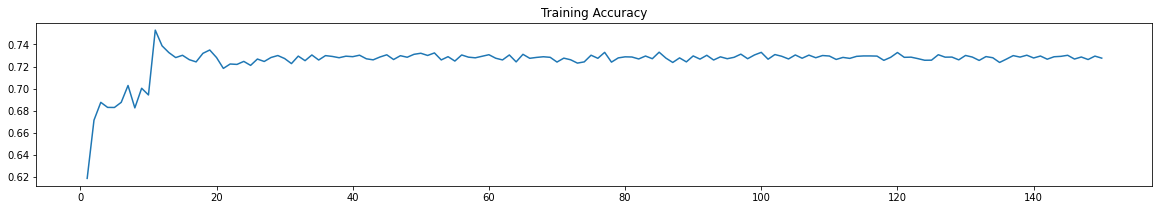

In [18]:
plt.rcParams["figure.figsize"] = (20,3)
plt.title("Training Accuracy")
plt.plot(x_params[:150], accuracy_pts[:150])

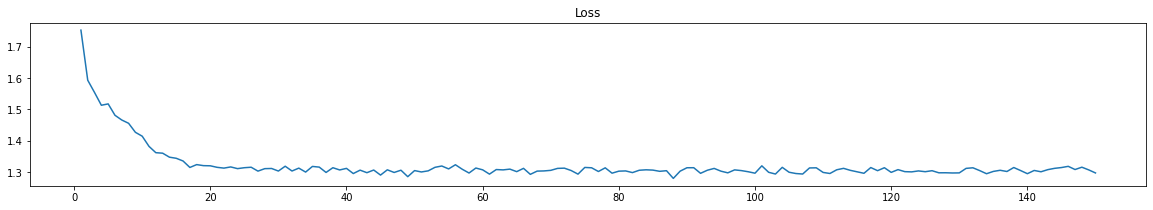

In [19]:

plt.title("Loss")
plt.plot(x_params[:150], loss_pts[:150])

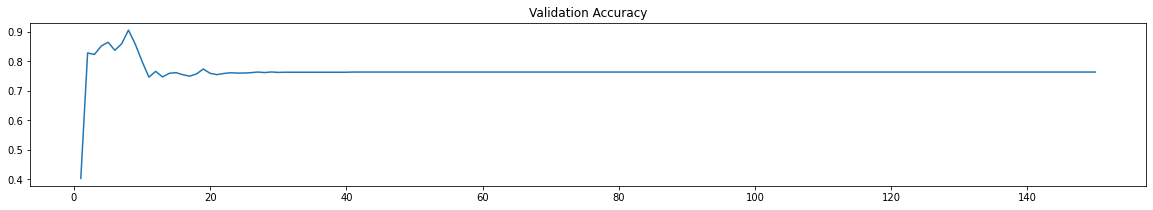

In [20]:
plt.title("Validation Accuracy")
plt.plot(x_params[:150], validation_accuracy_pts[:150])

In [15]:

test_dataset = EEGGraphDataset(X=X_test, y=y_test, indices=[i for i in range(len(X_test))], loader_type="test", sfreq=SFREQ, transform=Compose([ToTensor()]))
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = WORKERS)
model.eval()
with torch.no_grad():
	y_probs_val = torch.empty(0, 9).to(DEVICE)
	y_true_val = [ ]
	y_pred_val = [ ]
	window_indices_val = [ ]
	for i, batch in enumerate(test_loader):
			X_batch = batch.to(device=DEVICE, non_blocking=True)
			y_batch = torch.tensor(batch.y)
			y_batch = y_batch.to(device=DEVICE, non_blocking=True)
			window_indices_val += X_batch.dataset_idx.cpu().numpy().tolist()
			try:
				outputs = model(X_batch.x, X_batch.edge_index, X_batch.edge_attr, X_batch.batch).float()
				loss = loss_function(outputs, y_batch)
				val_loss.append(loss.item())
				_, predicted = torch.max(outputs.data, 1)
				y_pred_val += predicted.cpu().numpy().tolist()
				y_probs_val = torch.cat((y_probs_val, outputs.data), 0)
				y_true_val += y_batch.cpu().numpy().tolist()
			except:
				pass
y_probs_val = torch.nn.functional.softmax(y_probs_val, dim=1).cpu().numpy()
y_true_val = np.array(y_true_val)
print(f"Test Accuracy : {sklearn.metrics.accuracy_score(y_true_val, y_pred_val):.3f}")

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Test Accuracy : 0.744


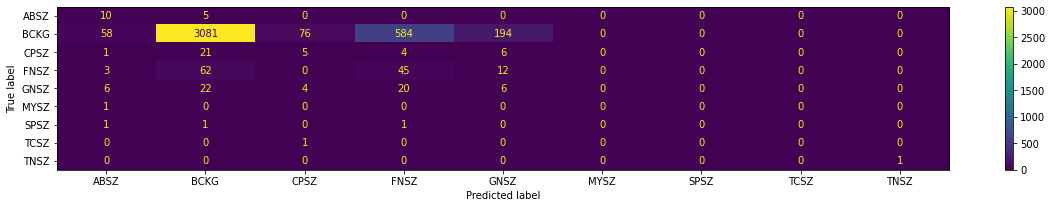

In [16]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true_val, y_pred_val)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_mapping)
#cm_display.plot()
plt.rcParams["figure.figsize"] = (20,3)
cm_display.plot()
plt.axis('tight')
plt.show()

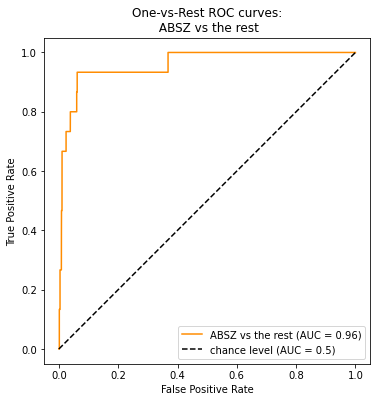

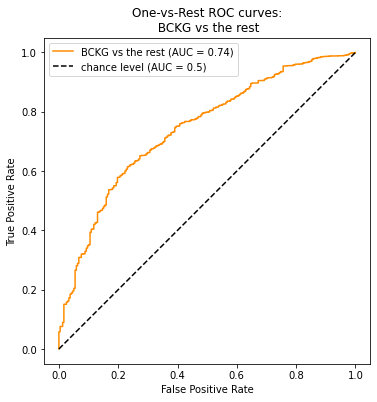

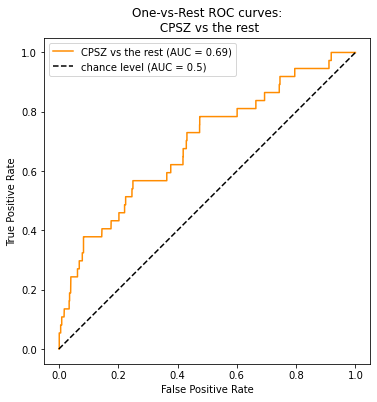

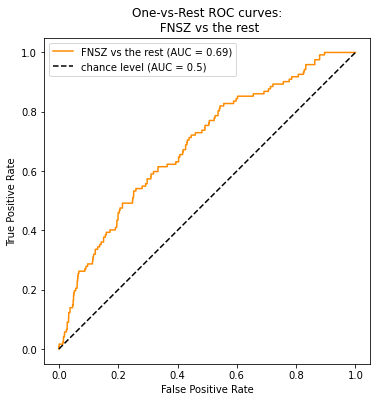

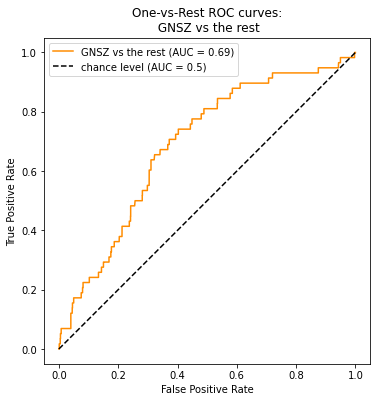

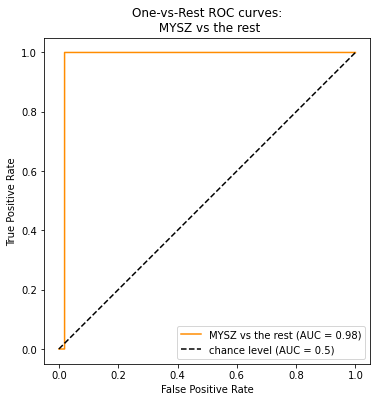

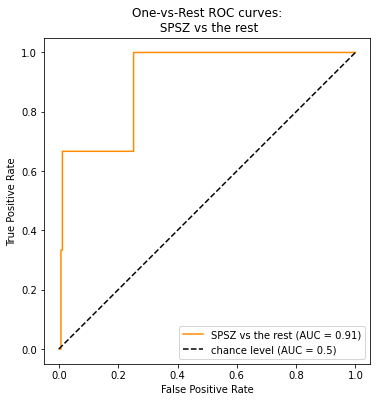

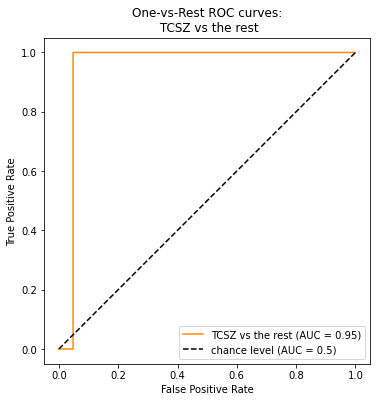

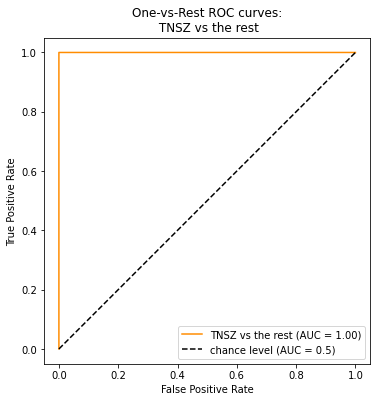

In [17]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
plt.rcParams["figure.figsize"] = (6,6)
for lb in range(9):
    label_binarizer.transform([lb])
    class_of_interest = lb
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    y_predicted = np.array(y_probs_val)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_predicted[:, class_id],
        name=f"{label_mapping[class_of_interest]} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n {label_mapping[class_of_interest]} vs the rest")
    plt.legend()
    plt.show()